In [2]:
import pandas as pd
import numpy as np

# read data from Aurora/Redshift (for writing may be some already made utilies in db_tools)
from db_tools.data_manager import sql_to_pandas, sql_to_pandas_big
from db_tools.request_data import RequestData
from db_tools.object_repository import ObjectRepository

from common.logger import logger
from common.data_utils.df_utils import sql_list_to_tuple

from python_engine.pipelines.pipeline_repository import PipelineRepository, BUCKET
from python_engine.data.sales import SalesRepository
from python_engine.data.category import CategoryRepository
from python_engine.data.store import StoreRepository
from python_engine.data.product import ProductRepository
from python_engine.data.stocks import StocksRepository
from python_engine.modules.features.transformations.apply_rolling_mean import apply_rolling_mean
from python_engine.modules.features.product.repository import ProductFeaturesRepository
from python_engine.modules.features.transformations.fill_dates import fill_dates
from python_engine.modules.common.dataframes.cartesian_merge import merge_cartesian

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

import datetime

import matplotlib.pyplot as plt
# import seaborn as sns
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import json

# read/write data in S3

# tables/dataframes
# https://github.com/nextail/py-db-tools/blob/master/db_tools/s3_utils.py
# Note 1: also the DataFrame/parquet version
# Note 2: also some utilities with the url version (not needed to pass the bucket). If you want write the rest and do a PR! :)
from db_tools.s3_utils import save_df_to_csv_in_s3, read_df_from_csv_in_s3, read_df_from_csv_in_s3_url

# any file (JSON for example)
from db_tools.object_repository import ObjectRepository
from common.logger import logger

# you may want to use another searilirez so you don't depend on python-engine
# from python_engine.modules.common.util.json_utils import serialize_to_str

In [3]:
client = 'pimkie'
environment = 'sandbox'
request_data = RequestData(client=client, environment=environment)
request_data.aurora_con, request_data.redshift_con

(<sqlalchemy.engine.base.Connection at 0x7f04ed6ace10>,
 <sqlalchemy.engine.base.Connection at 0x7f04c4a236d8>)

In [4]:
folder_url = 's3://production-data-science-nextail.co/seasonality_data/client=pimkie/execution_id=4c668958-acbb-4f91-bbfa-8644cdfa55d4'

In [5]:
STORE_PRODUCT_CLUSTERS = 'store_product_clusters.csv'
SEASONALITY_STORE_PRODUCT_CLUSTERS = 'seasonality_store_product_clusters.csv'
STORE_WEEKDAY_WEIGHTS = 'store_weekday_weights.csv'

In [6]:
store_product_clusters = read_df_from_csv_in_s3_url(f'{folder_url}/{STORE_PRODUCT_CLUSTERS}')
seasonality_store_product_clusters = read_df_from_csv_in_s3_url(f'{folder_url}/{SEASONALITY_STORE_PRODUCT_CLUSTERS}')
store_weekday_weights = read_df_from_csv_in_s3_url(f'{folder_url}/{STORE_WEEKDAY_WEIGHTS}')

In [7]:
today = datetime.date.today().strftime('%Y-%m-%d')
print(type(today))

<class 'str'>


# - Repositories for sales and stock

In [8]:
sales_repo = SalesRepository(request_data)

In [9]:
stock_repo = StocksRepository(request_data)

# - Create a product_sku dataframe and a feature dataframe

In [10]:
sql = f'''
        WITH domain as (
        SELECT DISTINCT products.switch_product_id AS switch_product_id
        FROM products
        WHERE TRUE
        )
        SELECT DISTINCT switch_product_id as product_id, skus.switch_sku_id as sku_id, families.name as family, 
        seasons.name as season, products.full_price as price
        FROM domain
        JOIN products USING(switch_product_id)
        JOIN skus ON skus.product_id = products.id
        JOIN families ON families.id = products.family_id
        JOIN seasons ON seasons.id = products.season_id
        WHERE products.family_id = 8
        ORDER BY product_id
        '''

sql_data = sql_to_pandas_big(sql, request_data.redshift_con)
features_products_2 = sql_data[['product_id', 'family', 'season', 'price']].drop_duplicates()
product_sku = sql_data[['product_id', 'sku_id']]

In [11]:
features_products_2.head(3)

,product_id,family,season,price
0,2134,T-Shirt,2018S,4.0
1,2135,T-Shirt,2018S,4.0
2,2145,T-Shirt,2018S,6.0


In [12]:
features_products_2['price'] = round(features_products_2['price'])
features_products_2.reset_index(inplace=True, drop=True)
features_products_2['year_season'] = [elem[0:4] if type(elem)==str else elem for elem in features_products_2['season']]
features_products_2['season'] = [elem[-1] if type(elem)==str else elem for elem in features_products_2['season']]
features_products_2['season'].replace({'S':'summer', 'W':'winter'}, inplace=True)
features_products_2.head()

,product_id,family,season,price,year_season
0,2134,T-Shirt,summer,4.0,2018
1,2135,T-Shirt,summer,4.0,2018
2,2145,T-Shirt,summer,6.0,2018
3,2146,T-Shirt,summer,6.0,2018
4,2150,T-Shirt,summer,6.0,2018


In [13]:
features_products_2 = pd.get_dummies(data=features_products_2, columns = ['family', 'season'])
features_products = features_products_2.drop(columns={'year_season'}, axis=1)
features_products.head()

,product_id,price,family_T-Shirt,season_summer,season_winter
0,2134,4.0,1,1,0
1,2135,4.0,1,1,0
2,2145,6.0,1,1,0
3,2146,6.0,1,1,0
4,2150,6.0,1,1,0


In [14]:
#features_products.to_csv('new_data/features_products.csv')

In [15]:
product_sku.head()

,product_id,sku_id
0,2134,16060
1,2135,16070
2,2145,16140
3,2146,16144
4,2146,16143


In [16]:
product_n_sku = product_sku.groupby('product_id').agg({'sku_id': [pd.Series.nunique]})
product_n_sku.columns = product_n_sku.columns.droplevel(1)
product_n_sku.rename({'sku_id': 'skus'}, axis=1, inplace=True)
product_n_sku.reset_index(drop=False, inplace=True)
product_n_sku.head()

,product_id,skus
0,2134,5
1,2135,6
2,2136,4
3,2137,6
4,2138,4


### - List of product_ids and sku_ids

In [17]:
product_ids = tuple(product_sku['product_id'].unique())
sku_ids = tuple(product_sku['sku_id'].unique())

In [18]:
len(product_ids)

3034

# - Sales and stock of product_ids

- sales

In [19]:
sales_all = sales_repo.get_sales(min_date='2010-01-01', max_date=today, ids=product_ids, with_returns=True, include_linked_lines=True)
sales_all.reset_index(drop=True, inplace=True)
sales_all.head()

,date,store_id,product_id,quantity
0,2017-12-10,654,2546,1
1,2017-12-10,17,2652,-1
2,2017-12-10,121,2663,1
3,2017-12-10,173,2663,1
4,2017-12-10,449,2663,2


In [35]:
sales_tshirts = sales_all[sales_all['product_id'].isin(product_ids)].reset_index(drop=True)
sales_tshirts.head()

,date,store_id,product_id,quantity
0,2017-12-10,654,2546,1
1,2017-12-10,17,2652,-1
2,2017-12-10,121,2663,1
3,2017-12-10,173,2663,1
4,2017-12-10,449,2663,2


In [36]:
sales_tshirts.product_id.nunique()

2813

In [40]:
sales_tshirts['first_sale'] = sales_tshirts.groupby('product_id')['date'].transform('min')
sales_tshirts['one_year_from_first_sale'] = sales_tshirts['first_sale'] + pd.offsets.DateOffset(years = 1)

sales_tshirts = sales_tshirts[(sales_tshirts['date']>=sales_tshirts['first_sale']) & 
                              (sales_tshirts['first_sale']<='2020-7-1') & ### filter those new items
                              (sales_tshirts['date']<=sales_tshirts['one_year_from_first_sale'])]
sales_tshirts.drop(['one_year_from_first_sale'], axis=1, inplace=True)

sales_tshirts['month'] = sales_tshirts['date'].dt.month
sales_tshirts['year'] = sales_tshirts['date'].dt.year
sales_tshirts['launch_month'] = sales_tshirts['first_sale'].dt.month

sales_tshirts.drop(['first_sale'], axis=1, inplace=True)

sales_tshirts.sort_values(['product_id', 'store_id', 'date'], inplace=True)
sales_tshirts.reset_index(drop=True, inplace=True)

sales_tshirts = sales_tshirts[sales_tshirts['year']!=2020]

display(sales_tshirts.head())
print(sales_tshirts.shape)

,date,store_id,product_id,quantity,month,year,launch_month
0,2018-02-17,1,2134,1,2,2018,2
1,2018-02-20,1,2134,3,2,2018,2
2,2018-02-21,1,2134,1,2,2018,2
3,2018-03-01,1,2134,1,3,2018,2
4,2018-03-05,1,2134,2,3,2018,2


(12399829, 7)


In [41]:
sales_tshirts.product_id.nunique()

1921

In [42]:
sales_tshirts.head()

,date,store_id,product_id,quantity,month,year,launch_month
0,2018-02-17,1,2134,1,2,2018,2
1,2018-02-20,1,2134,3,2,2018,2
2,2018-02-21,1,2134,1,2,2018,2
3,2018-03-01,1,2134,1,3,2018,2
4,2018-03-05,1,2134,2,3,2018,2


In [61]:
launch_month_feature = sales_tshirts[['product_id','launch_month']]
launch_month_feature = launch_month_feature.drop_duplicates().reset_index(drop = True)
display(launch_month_feature)
launch_month_feature.to_csv('launch_month_feature.csv',index =False)

,product_id,launch_month
0,2134,2
1,2135,2
2,2136,2
3,2137,1
4,2138,1
5,2139,1
6,2144,3
7,2145,1
8,2146,2
9,2149,1


In [43]:
sales_tshirts_agg = sales_tshirts.groupby(['product_id', 'store_id', 'month', 'year']).agg({'quantity': ['sum']})

sales_tshirts_agg.columns = sales_tshirts_agg.columns.droplevel(1)
sales_tshirts_agg.reset_index(inplace=True, drop=False)
sales_tshirts_agg.rename(columns={'quantity': 'quantity_sales'}, inplace=True)

display(sales_tshirts_agg.head())

,product_id,store_id,month,year,quantity_sales
0,2134,1,2,2018,5
1,2134,1,3,2018,14
2,2134,1,4,2018,11
3,2134,1,5,2018,2
4,2134,2,2,2018,2


# continue here

In [44]:
stock_tshirts_agg_sku = pd.read_csv('t_stocks.csv')

- Merge

In [45]:
tshirts = pd.merge(stock_tshirts_agg_sku, sales_tshirts_agg, 
                   on=['product_id', 'store_id', 'month', 'year'],
                  how = 'inner')
tshirts.sort_values(['product_id', 'year', 'month', 'store_id'], inplace=True)
tshirts.reset_index(drop=True, inplace=True)
tshirts.head()

,Unnamed: 0,product_id,store_id,month,year,stock,quantity_sales
0,0,2134,1,2,2018,9,5
1,2,2134,2,2,2018,9,2
2,8,2134,4,2,2018,7,2
3,11,2134,5,2,2018,5,1
4,13,2134,6,2,2018,7,8


In [46]:
tshirts_potential = tshirts.groupby(['product_id', 'year', 'month']).agg({'store_id': pd.Series.nunique, 'stock': 'sum', 'quantity_sales': 'sum'})
tshirts_potential.rename(columns={'store_id': 'stores_count'}, inplace=True)
tshirts_potential.head()

stores_count  stock  quantity_sales
product_id year month                                     
2134       2018 2               401   3206            1192
                3               685  10363            6624
                4               553   8246            4685
                5                87   1124             342
                6                27    384             136

# - sales per month

In [47]:
tshirts_sales_month = tshirts_potential.drop(columns={'stores_count', 'stock'}, axis=1)
tshirts_sales_month.head()

quantity_sales
product_id year month                
2134       2018 2                1192
                3                6624
                4                4685
                5                 342
                6                 136

In [48]:
tshirts_sales_month = tshirts_sales_month.quantity_sales.unstack().reset_index()
tshirts_sales_month.head()

month,product_id,year,1,2,3,4,5,6,7,8,9,10,11,12
0,2134,2018,NaN,1192.0,6624.0,4685.0,342.0,136.0,82.0,3.0,NaN,NaN,NaN,NaN
1,2135,2018,NaN,1769.0,10582.0,10831.0,15342.0,11820.0,2153.0,107.0,6.0,8.0,NaN,NaN
2,2136,2018,NaN,1397.0,7653.0,8759.0,11565.0,10066.0,1897.0,52.0,12.0,NaN,NaN,NaN
3,2137,2018,125.0,703.0,2242.0,4337.0,3442.0,1670.0,813.0,4.0,3.0,1.0,NaN,NaN
4,2138,2018,98.0,910.0,2211.0,920.0,154.0,465.0,823.0,10.0,4.0,NaN,NaN,NaN


In [49]:
tshirts_sales_month = tshirts_sales_month[tshirts_sales_month['year']!=2021]

In [50]:
tshirts_sales_month.to_csv('tshirts_12_months.csv')

In [51]:
tshirts_sales_month.product_id.nunique()

1805

In [52]:
d = {i:'max' for i in range(1,13)}
tshirts_sales_month_final = tshirts_sales_month.groupby('product_id').aggregate(d).reset_index()

col = [i for i in range(1,13)]
tshirts_sales_month_final['max'] = tshirts_sales_month_final[col].max(axis = 1)
## remove some noise products(have small max_sales)
tshirts_sales_month_final = tshirts_sales_month_final[tshirts_sales_month_final['max']>300].reset_index(drop = True)
display(tshirts_sales_month_final)

,product_id,1,2,3,4,5,6,7,8,9,10,11,12,max
0,2134,NaN,1192.0,6624.0,4685.0,342.0,136.0,82.0,3.0,NaN,NaN,NaN,NaN,6624.0
1,2135,NaN,1769.0,10582.0,10831.0,15342.0,11820.0,2153.0,107.0,6.0,8.0,NaN,NaN,15342.0
2,2136,NaN,1397.0,7653.0,8759.0,11565.0,10066.0,1897.0,52.0,12.0,NaN,NaN,NaN,11565.0
3,2137,125.0,703.0,2242.0,4337.0,3442.0,1670.0,813.0,4.0,3.0,1.0,NaN,NaN,4337.0
4,2138,98.0,910.0,2211.0,920.0,154.0,465.0,823.0,10.0,4.0,NaN,NaN,NaN,2211.0
5,2139,NaN,1138.0,2436.0,4174.0,2427.0,1450.0,652.0,14.0,NaN,NaN,NaN,NaN,4174.0
6,2144,NaN,NaN,NaN,1152.0,1010.0,242.0,165.0,NaN,NaN,NaN,NaN,NaN,1152.0
7,2145,2830.0,4552.0,3471.0,352.0,17.0,10.0,6.0,2.0,12.0,NaN,NaN,NaN,4552.0
8,2146,NaN,1262.0,3198.0,745.0,89.0,14.0,5.0,NaN,NaN,NaN,NaN,NaN,3198.0
9,2153,1710.0,2408.0,5194.0,1889.0,194.0,190.0,360.0,20.0,8.0,3.0,NaN,NaN,5194.0


In [53]:
launch_month = []


In [54]:
tshirts_sales_month_final = tshirts_sales_month_final.fillna(0)
tshirts_sales_scaled = tshirts_sales_month_final.copy(deep = True)
for i in col:
    tshirts_sales_scaled[i] = tshirts_sales_scaled[i]/tshirts_sales_scaled['max']
display(tshirts_sales_scaled.head())
# tshirts_sales_scaled.to_csv('tshirts_scaled_sales.csv')

,product_id,1,2,3,4,5,6,7,8,9,10,11,12,max
0,2134,0.000000,0.179952,1.000000,0.707277,0.051630,0.020531,0.012379,0.000453,0.000000,0.000000,0.0,0.0,6624.0
1,2135,0.000000,0.115304,0.689741,0.705971,1.000000,0.770434,0.140334,0.006974,0.000391,0.000521,0.0,0.0,15342.0
2,2136,0.000000,0.120796,0.661738,0.757371,1.000000,0.870385,0.164029,0.004496,0.001038,0.000000,0.0,0.0,11565.0
3,2137,0.028822,0.162094,0.516947,1.000000,0.793636,0.385059,0.187457,0.000922,0.000692,0.000231,0.0,0.0,4337.0
4,2138,0.044324,0.411578,1.000000,0.416101,0.069652,0.210312,0.372230,0.004523,0.001809,0.000000,0.0,0.0,2211.0


# Graph

In [61]:
number_selected = 5
random_data = tshirts_sales_month_final.sample(n=number_selected,random_state = 0).reset_index(drop=True)
list_selected = list(random_data.product_id)
display(random_data)

,product_id,1,2,3,4,5,6,7,8,9,10,11,12,max
0,3393,134.0,32.0,10.0,3.0,0.0,1.0,223.0,261.0,981.0,230.0,41.0,24.0,981.0
1,4097,0.0,0.0,0.0,0.0,510.0,1439.0,515.0,70.0,3.0,16.0,0.0,1.0,1439.0
2,4008,0.0,0.0,700.0,2040.0,1262.0,947.0,662.0,233.0,17.0,9.0,4.0,7.0,2040.0
3,2227,15.0,61.0,640.0,261.0,99.0,113.0,835.0,429.0,12.0,2.0,3.0,4.0,835.0
4,2367,0.0,0.0,640.0,4401.0,254.0,90.0,32.0,2.0,0.0,0.0,5.0,0.0,4401.0


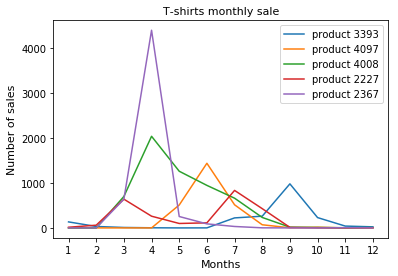

In [62]:
# import matplotlib
# c = cm.rainbow(int(255/8 * s))
x = np.array([i for i in range(1,13)])
for i in range(number_selected):
    plt.plot(x,random_data.iloc[i,1:-1],label = 'product {}'.format(random_data.loc[i,'product_id']))
plt.xlabel('Months', fontsize = 11)
plt.ylabel('Number of sales', fontsize = 11)
plt.xticks(np.arange(1,13,1))
plt.title('T-shirts monthly sale', fontsize = 11)
plt.legend()
# plt.savefig('monthly sale.pdf',dpi = 600)
plt.show()

In [63]:
display(list_selected)
scaled_random_data = tshirts_sales_scaled[tshirts_sales_scaled.product_id.isin(list_selected)].reset_index(drop = True)
display(scaled_random_data)

[3393, 4097, 4008, 2227, 2367]

,product_id,1,2,3,4,5,6,7,8,9,10,11,12,max
0,2227,0.017964,0.073054,0.766467,0.312575,0.118563,0.135329,1.000000,0.513772,0.014371,0.002395,0.003593,0.004790,835.0
1,2367,0.000000,0.000000,0.145421,1.000000,0.057714,0.020450,0.007271,0.000454,0.000000,0.000000,0.001136,0.000000,4401.0
2,3393,0.136595,0.032620,0.010194,0.003058,0.000000,0.001019,0.227319,0.266055,1.000000,0.234455,0.041794,0.024465,981.0
3,4008,0.000000,0.000000,0.343137,1.000000,0.618627,0.464216,0.324510,0.114216,0.008333,0.004412,0.001961,0.003431,2040.0
4,4097,0.000000,0.000000,0.000000,0.000000,0.354413,1.000000,0.357887,0.048645,0.002085,0.011119,0.000000,0.000695,1439.0


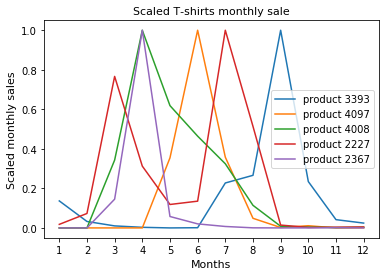

In [64]:
x = np.array([i for i in range(1,13)])
for i in list_selected:
    plt.plot(x,tshirts_sales_scaled[tshirts_sales_scaled['product_id']==i].iloc[:,1:-1].values.reshape(12,),
             label = 'product {}'.format(i))
plt.xlabel('Months', fontsize = 11)
plt.ylabel('Scaled monthly sales', fontsize = 11)
plt.xticks(np.arange(1,13,1))
plt.title('Scaled T-shirts monthly sale', fontsize = 11)
plt.legend()
# plt.savefig('scaled monthly sale.pdf',dpi = 600)
plt.show()